# **Roman Urdu Sentiment Classification – Modeling Experiment**

This project focuses on building a sentiment classification model for Roman Urdu text using a publicly available dataset from Hugging Face: [romanurdu-sentiment-dataset](https://huggingface.co/datasets/HowMannyMore/romanurdu-sentiment-dataset).

<img src="image.png" alt="Alt Text" style="width:500px; float:right; margin-right:20px;" />

### Motivation

As someone who frequently uses Roman Urdu in online communication, I was particularly interested in understanding how effectively machine learning models can interpret and classify sentiments expressed in this informal, non-standardized script. Roman Urdu presents unique challenges due to inconsistent spelling, lack of formal grammar rules, and rich use of colloquial expressions, making it a compelling area for experimentation in natural language processing (NLP).

### Dataset

The dataset comprises Roman Urdu text samples labeled with sentiment categories. It serves as a valuable resource for testing how well traditional NLP techniques perform on low-resource, informal languages.

### Modeling Approach

For this experiment, I'm using the `scikit-learn` library to implement a traditional machine learning pipeline. The steps include:

- **TF-IDF Vectorization**: Transforming text data into numerical features.
- **Label Encoding**: Converting categorical sentiment labels into numerical format.
- **Classification**: Training a **Logistic Regression** model as the baseline classifier.

I will evaluate model performance using standard metrics:
- **Accuracy**
- **Precision, Recall, and F1-Score**
- **Confusion Matrix**

Depending on initial results, I may also explore alternative models such as Support Vector Machines (SVM), Random Forests, or even experiment with deep learning using TensorFlow.

### Code Repository

All code and related documentation for this project can be found on GitHub:  
 [roman-urdu-sentiment-analysis](https://github.com/amyasma/roman-urdu-sentiment-analysis.git)


## Imports 
Let's begin by importing the necessary libraries for data handling, preprocessing, model training, and evaluation.

In [4]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import numpy as np
import re

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from keras import layers

## Step 1: Load the Dataset
To begin, we will load the Roman Urdu sentiment dataset directly from *Hugging Face* using the *datasets* library. This library provides a convenient interface for accessing a wide variety of NLP datasets. Once loaded, we'll convert the dataset into a pandas DataFrame for easier manipulation and analysis.

In [8]:
# Step 1: Load the dataset from Hugging Face
dataset = load_dataset("HowMannyMore/romanurdu-sentiment-dataset")

# Convert to pandas DataFrame (train split only for now)
data = dataset["train"].to_pandas()

# let's view the first five rows. 
data.head()

,text,label
0,namoona word bolungi unhe ek ghoori deni mujhe...,Negative
1,sir ya kitni month ya years work kra gi?? btw ...,Positive
2,bhot acha ha shekk bhot umda,Positive
3,mashaalla give wisdom to our muslims afghan br...,Neutral
4,hazrat sahab salam mari wife bohat beemar hai ...,Neutral


We can also view the characteristics of our data with the help of pandas. For example, let's see how many samples there are for each labels to know what we are dealing with:

In [10]:
data['label'].value_counts()

label
Neutral     20247
Negative    20018
Positive    19925
Name: count, dtype: int64

## Step 2: Normalize the Text

Before moving on to model training, it’s important to ensure the input text is clean and consistent. In this step, we remove any rows with missing values in the text or label columns and apply normalization. This includes:

- Removing emojis
- Removing punctuation
- Reducing repeated characters (e.g., "bohott" → "bohot")
- Converting all text to lowercase
  
This normalization helps improve model performance, especially for informal text like Romanized Urdu, where spelling and formatting are highly inconsistent.

In [12]:
# Step 2: Drop any rows with missing values
data.dropna(subset=["text", "label"], inplace=True)

# testing that dropna() worked by using isnull().sum() that gives a sum of null values.
data.isnull().sum()

text     0
label    0
dtype: int64

In [13]:
emoji_pattern = re.compile(
    "["
    u"\U0001F600-\U0001F64F"  # Emoticons
    u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # Transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # Flags (iOS)
    u"\U00002700-\U000027BF"  # Dingbats
    u"\U000024C2-\U0001F251"  # Enclosed characters
    "]+", flags=re.UNICODE
)

def normalize_text(text):
    text = text.lower()
    text = emoji_pattern.sub(r'', text)            # Remove emojis
    text = re.sub(r'[^\w\s]', '', text)            # Remove punctuation
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)      # Limit repeated characters

    tokens = text.split()
    return " ".join(tokens)

# Apply to your dataset
data['text_cleaned'] = data['text'].apply(normalize_text)

# Preview
data.head()


,text,label,text_cleaned
0,namoona word bolungi unhe ek ghoori deni mujhe...,Negative,namoona word bolungi unhe ek ghoori deni mujhe...
1,sir ya kitni month ya years work kra gi?? btw ...,Positive,sir ya kitni month ya years work kra gi btw mu...
2,bhot acha ha shekk bhot umda,Positive,bhot acha ha shekk bhot umda
3,mashaalla give wisdom to our muslims afghan br...,Neutral,mashaalla give wisdom to our muslims afghan br...
4,hazrat sahab salam mari wife bohat beemar hai ...,Neutral,hazrat sahab salam mari wife bohat beemar hai ...


## Step 3: Encode Sentiment Labels

Machine learning models work with numerical data, so we need to convert the sentiment labels (e.g., positive, negative, neutral) into numeric format. We'll use LabelEncoder from scikit-learn to perform this transformation.

In [15]:
# Initialize the label encoder
le = LabelEncoder()

# Fit the encoder and transform the sentiment labels
data['label_encoded'] = le.fit_transform(data['label'])


Let's see if it worked

In [17]:
# Display the mapping for reference
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping: \n", label_mapping, "\n")

# Preview the updated DataFrame
data.head()

Label Mapping: 
 {'Negative': 0, 'Neutral': 1, 'Positive': 2} 



,text,label,text_cleaned,label_encoded
0,namoona word bolungi unhe ek ghoori deni mujhe...,Negative,namoona word bolungi unhe ek ghoori deni mujhe...,0
1,sir ya kitni month ya years work kra gi?? btw ...,Positive,sir ya kitni month ya years work kra gi btw mu...,2
2,bhot acha ha shekk bhot umda,Positive,bhot acha ha shekk bhot umda,2
3,mashaalla give wisdom to our muslims afghan br...,Neutral,mashaalla give wisdom to our muslims afghan br...,1
4,hazrat sahab salam mari wife bohat beemar hai ...,Neutral,hazrat sahab salam mari wife bohat beemar hai ...,1


## Step 4: TF-IDF Vectorization

To convert the Roman Urdu text into numerical features that a machine learning model can understand, we use TF-IDF (Term Frequency–Inverse Document Frequency) vectorization. This technique highlights important words and reduces the weight of common, less informative ones.

We'll use TfidfVectorizer from scikit-learn with the following settings:

- max_features=5000: Limits the vocabulary to the top 5,000 most frequent terms.
- ngram_range=(1, 2): Includes both unigrams (single words) and bigrams (pairs of consecutive words).

*(instead of using X and y I intentionally used tfidf and labels to make it clear what we are working with)*

In [19]:
# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))

# Transform the text data into TF-IDF features
X = vectorizer.fit_transform(data["text_cleaned"])

# Target labels
y = data["label_encoded"]

# see tfidf until 1
print (X [:1])
# see labels
print (y[:4])

  (0, 5356)	0.3393096371753464
  (0, 833)	0.3042348850507124
  (0, 9225)	0.3519956708954517
  (0, 8864)	0.18994214349430852
  (0, 5301)	0.12144924796869044
  (0, 832)	0.2716926604642787
  (0, 1320)	0.14140694866216819
  (0, 9223)	0.17968132891415123
  (0, 9494)	0.3166107356977849
  (0, 6420)	0.20066619387590343
  (0, 2152)	0.3166107356977849
  (0, 2405)	0.21197520804680606
  (0, 9317)	0.3088613180642841
  (0, 9727)	0.3322688189635369
0    0
1    2
2    2
3    1
Name: label_encoded, dtype: int64


## Step 5: Train-Test Split

To evaluate the model's performance, we divide the dataset into training and testing subsets. This helps ensure that the model is evaluated on unseen data, providing a more reliable measure of its generalization capability.

We use train_test_split from scikit-learn with the following parameters:

- test_size = Allocates 20% of the data for testing.
- random_state = Sets a fixed seed for reproducibility.

Our tfidf will be *'X'* for input and our labels will be *'y'* for the target/predicted output that are the standard terms. 

In [21]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


## Step 6: Create Logistic Regression Model Using TensorFlow

In this step, we will implement a logistic regression model using TensorFlow. While logistic regression is commonly built using scikit-learn, we are opting for TensorFlow to take advantage of its flexibility and built-in support for tracking training metrics such as accuracy and loss over epochs.

We define a simple model with a single dense output layer using a softmax activation function, suitable for multiclass classification.

In [23]:
model = Sequential([
    Dense(60, activation='relu', input_shape=(X_train.shape[1],),
          kernel_regularizer=regularizers.l2(0.00001)),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.00001)),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Step 7: Train the Network

In [25]:
# Step 5: Train the model

early_stop = EarlyStopping(
    monitor='val_loss',      # Stop when validation loss stops improving
    patience=5,              # Wait 2 epochs before stopping
    restore_best_weights=True  # Restore model weights from the epoch with best val_loss
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]  
)


Epoch 1/50
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.6412 - loss: 0.8052 - val_accuracy: 0.7710 - val_loss: 0.5700
Epoch 2/50
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8227 - loss: 0.4707 - val_accuracy: 0.7751 - val_loss: 0.5723
Epoch 3/50
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8604 - loss: 0.3863 - val_accuracy: 0.7732 - val_loss: 0.6082
Epoch 4/50
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8922 - loss: 0.3219 - val_accuracy: 0.7748 - val_loss: 0.6592
Epoch 5/50
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9107 - loss: 0.2739 - val_accuracy: 0.7770 - val_loss: 0.7109
Epoch 6/50
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9256 - loss: 0.2407 - val_accuracy: 0.7765 - val_loss: 0.7639


## Step 8: Evaluate Model Performance

After training, we evaluate the model's performance on the test set by generating a classification report. Since TensorFlow's model.predict() returns class probabilities, we use argmax to convert them into predicted labels

In [27]:
# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Generate and display classification report
print("\n**Classification Report**\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")


377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

**Classification Report**

              precision    recall  f1-score   support

    Negative       0.81      0.77      0.79      4070
     Neutral       0.73      0.75      0.74      4034
    Positive       0.78      0.79      0.79      3934

    accuracy                           0.77     12038
   macro avg       0.77      0.77      0.77     12038
weighted avg       0.77      0.77      0.77     12038

377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7658 - loss: 0.5755
Test Accuracy: 0.7710


## Step 8: Predict Sentiment for New Roman Urdu Sentences

Now that the model is trained, we can use it to predict sentiments for new, unseen Roman Urdu sentences. These sentences will be transformed using the same TF-IDF vectorizer, and the model will output predicted sentiment labels.

In [29]:
# Sample Roman Urdu sentences
new_texts = [
    "mujhe ye film pasand nahi aayi",
    "bht acha drama tha",
    "sahi tha bas"
]

# Transform the new text using the same TF-IDF vectorizer
X_new = vectorizer.transform(new_texts).toarray()

# Predict probabilities and convert to class labels
pred_probs = model.predict(X_new)
pred_classes = np.argmax(pred_probs, axis=1)

# Convert numeric labels back to original sentiment labels
predicted_labels = le.inverse_transform(pred_classes)

# Display predictions
print("\n **Sentiment Predictions** \n")
for text, label in zip(new_texts, predicted_labels):
    print([text, label])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

 **Sentiment Predictions** 

['mujhe ye film pasand nahi aayi', 'Negative']
['bht acha drama tha', 'Positive']
['sahi tha bas', 'Neutral']


In [30]:
# Convert predicted class indices to actual labels using your label encoder

pred_labels = le.inverse_transform(y_pred)

summary = pd.Series(pred_labels).value_counts(normalize=True) * 100
summary = summary.round(2).astype(str) + '%'

print("\n**Sentiment Summary** \n")
print(summary)



**Sentiment Summary** 

Neutral     34.71%
Positive    32.93%
Negative    32.36%
Name: proportion, dtype: object


## Data Visualization:

To better understand the structure and distribution of the dataset, let's now explore it through visualizations.

### **Confusion Matrix**

A confusion matrix provides a detailed breakdown of the model's classification performance by showing the number of correct and incorrect predictions for each class. It helps identify which classes the model is confusing with others.

We will use ConfusionMatrixDisplay from scikit-learn to visualize it, with class labels displayed for clarity.

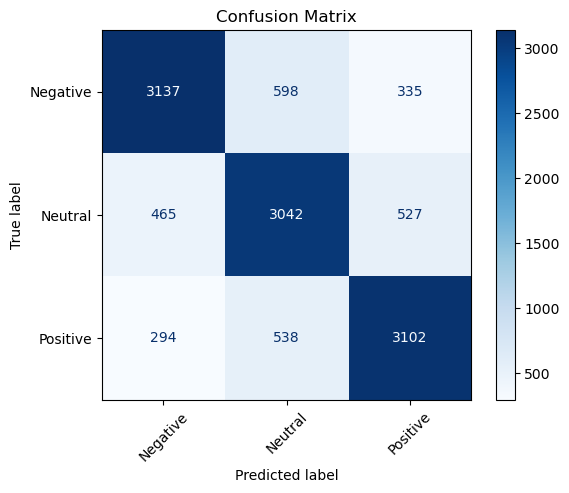

In [60]:
# Generate confusion matrix using predicted classes
cm = confusion_matrix(y_test, y_pred, labels=range(len(le.classes_)))

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


### **Accuracy VS Loss**

Let’s visualize how the model’s accuracy and loss evolved over each training epoch using Matplotlib. This helps us assess convergence, detect signs of overfitting, and better understand model behavior during training

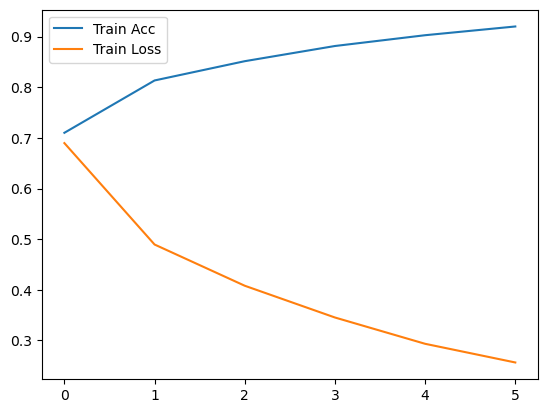

In [56]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.legend()
plt.show()


# Comments & Explanation

I developed a sentiment analysis system using a simple feedforward deep neural network, which achieved an accuracy of 77%. Initially, I experimented with an RNN using LSTM layers. However, I soon realized that this architecture was not well-suited to the nature of my dataset.

My dataset consists of Romanized Urdu, where Urdu is written using the English alphabet. One of the main challenges with Romanized Urdu is the lack of standardized spelling. For example, a single word like "kar" (to do) may appear as "kar," "kr," "ker," etc., depending on individual writing style. This variation made it difficult for the LSTM model to generalize effectively, and it only achieved around 34% accuracy, clearly underperforming.

Romanized Urdu also lacks linguistic resources such as stemming, lemmatization, or standard lexicons, which limited my ability to normalize the text. Aside from basic preprocessing like removing punctuation and emojis, there was not much more that could be done at the text level.

In contrast, a TF-IDF representation combined with a feedforward neural network handled these spelling inconsistencies far more efficiently, producing significantly better results. TF-IDF effectively captures word-level patterns without relying on sequence order or deep semantic context, making it well-suited for this kind of informal and inconsistent text.

I chose to use TensorFlow rather than scikit-learn to build the model, as TensorFlow offers more comprehensive tools for visualizing training metrics, such as accuracy and loss over epochs. These visualizations were especially useful for monitoring training progress and detecting overfitting. For evaluation, I incorporated scikit-learn’s confusion matrix, which provided a clear view of how well the model was performing across each sentiment category and helped highlight specific areas for improvement.